# Electricity Price Forecasting on the German day-ahead market

This notebook is the main interface to the associated EPF library. Various parameters can be adjusted within the library via the Config file. A more detailed description of the individual parameters can be found within the configuration classes. In the “exploratory_analysis” notebook, the raw data sets are analyzed exploratively and the results are displayed visually. Based on these results, features from the data sets were specifically selected for further use in the deep learning pipeline.

The forecasting pipeline is built to automatically perform data preprocessing including data cleaning, outlier removal and seasonal decomposition. Within the configuration feature engineering can be toggled on and of for each feature. Forecasting is done with three different models, that can be retrained and saved anytime. The models available are an LSTM, GRU and CNN. They all perform multi-step ahead, single shot forecasts. This means by default each forecast contains 24 time steps into the future, that are forecasted together in one computation.

In [1]:
from epf.pipeline import EpfPipeline

pipeline = EpfPipeline()

2025-05-07 16:49:43.479 | INFO     | epf.config:<module>:18 - PROJ_ROOT path is: C:\Users\valen\PycharmProjects\epf
2025-05-07 16:49:43.479 | INFO     | epf.config:create_dir:14 - DATA_DIR path is: C:\Users\valen\PycharmProjects\epf\data
2025-05-07 16:49:43.493 | INFO     | epf.config:create_dir:14 - RAW_DATA_DIR path is: C:\Users\valen\PycharmProjects\epf\data\raw
2025-05-07 16:49:43.493 | INFO     | epf.config:create_dir:14 - INTERIM_DATA_DIR path is: C:\Users\valen\PycharmProjects\epf\data\interim
2025-05-07 16:49:43.493 | INFO     | epf.config:create_dir:14 - PROCESSED_DATA_DIR path is: C:\Users\valen\PycharmProjects\epf\data\processed
2025-05-07 16:49:43.493 | INFO     | epf.config:create_dir:14 - TRAIN_DATA_DIR path is: C:\Users\valen\PycharmProjects\epf\data\processed\train_data
2025-05-07 16:49:43.493 | INFO     | epf.config:create_dir:14 - MODELS_DIR path is: C:\Users\valen\PycharmProjects\epf\models
2025-05-07 16:49:43.493 | INFO     | epf.config:create_dir:14 - PREDICTIONS_D

In [2]:
pipeline.train("lstm_all_features", overwrite=True, prep_data=True, use_tuned_hyperparams=False)

Trial 50 Complete [00h 00m 19s]
mean_absolute_error: 0.2018267959356308

Best mean_absolute_error So Far: 0.18226328492164612
Total elapsed time: 00h 27m 33s


C:\Users\valen\.virtualenvs\bachelor_arbeit\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-05-07 17:20:27.376 | INFO     | epf.pipeline:_tune_hyperparameters:290 - 
        The hyperparameter search is complete. The optimal number of units in the first densely-connected
        layer is 256 and the optimal learning rate for the optimizer
        is 0.001.
        
2025-05-07 17:20:27.376 | SUCCESS  | epf.pipeline:train:389 - Successfully tuned hyperparameters for lstm_all_features
2025-05-07 17:20:27.377 | INFO     | epf.pipeline:train:396 - Training lstm_all_features on the following Features:['DE-LU Prices', 'CH Prices', 'DK1 Prices', 'DK2 Prices', 'FR Prices', 'DE-LU Prices 7-Day Lag', 'DE-LU Prices 24-Hour Lag', 'DE-LU Prices 12-Hour Lag', 'DE-LU Prices 1-Hour Lag', 'DE Solar G

Epoch 1/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - loss: 0.0646 - mean_absolute_error: 0.1889 - val_loss: 0.6512 - val_mean_absolute_error: 0.5950
Epoch 2/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0554 - mean_absolute_error: 0.1750 - val_loss: 0.7402 - val_mean_absolute_error: 0.6443
Epoch 3/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0501 - mean_absolute_error: 0.1664 - val_loss: 0.6482 - val_mean_absolute_error: 0.6003
Epoch 4/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0466 - mean_absolute_error: 0.1603 - val_loss: 0.6228 - val_mean_absolute_error: 0.5807
Epoch 5/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0424 - mean_absolute_error: 0.1530 - val_loss: 0.7145 - val_mean_absolute_error: 0.6304
Epoch 6/20
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0392 - mean_absolute_error: 0.1471 - val_loss: 0.6477 - val_mean_absolute_error: 0.5941


2025-05-07 17:21:01.425 | SUCCESS  | epf.pipeline:train:402 - Successfully trained lstm_all_features.Now saving...


109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.6433 - mean_absolute_error: 0.5972


2025-05-07 17:21:02.467 | SUCCESS  | epf.pipeline:train:431 - Successfully saved lstm_all_features to C:/Users/valen/PycharmProjects/epf/models/lstm_all_features.keras


In [6]:
import pickle as pkl

with open("../data/processed/performance.pkl", "rb") as f:
    performance = pkl.load(f)

with open("../data/processed/val_performance.pkl", "rb") as f:
    val_performance = pkl.load(f)

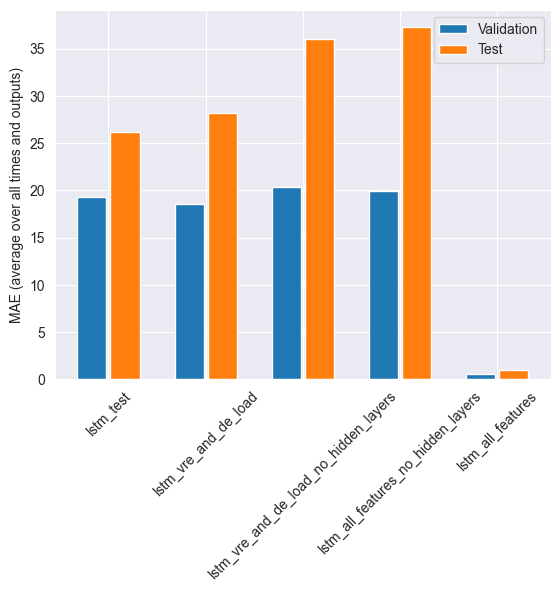

In [7]:
from matplotlib import pyplot as plt
import numpy as np

x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [31]:
from epf.config import PREDICTIONS_DIR, MODELS_DIR

window = pipeline.window
model_path = MODELS_DIR / "lstm_all_features.keras"
predictions_dir = PREDICTIONS_DIR

In [32]:
pipeline.predict(data=window.test, model_path=model_path, predictions_dir=predictions_dir)

2025-05-07 17:56:32.501 | INFO     | epf.pipeline:predict:453 - Loading model from C:\Users\valen\PycharmProjects\epf\models\lstm_all_features.keras.
2025-05-07 17:56:32.594 | SUCCESS  | epf.pipeline:predict:455 - Successfully loaded model from C:\Users\valen\PycharmProjects\epf\models\lstm_all_features.keras.


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


2025-05-07 17:56:33.164 | SUCCESS  | epf.pipeline:predict:458 - Successfully predicted features.
2025-05-07 17:56:33.164 | SUCCESS  | epf.pipeline:predict:463 - Successfully saved predictions to C:\Users\valen\PycharmProjects\epf\models\predictions\predictions_from_lstm_all_features.pkl


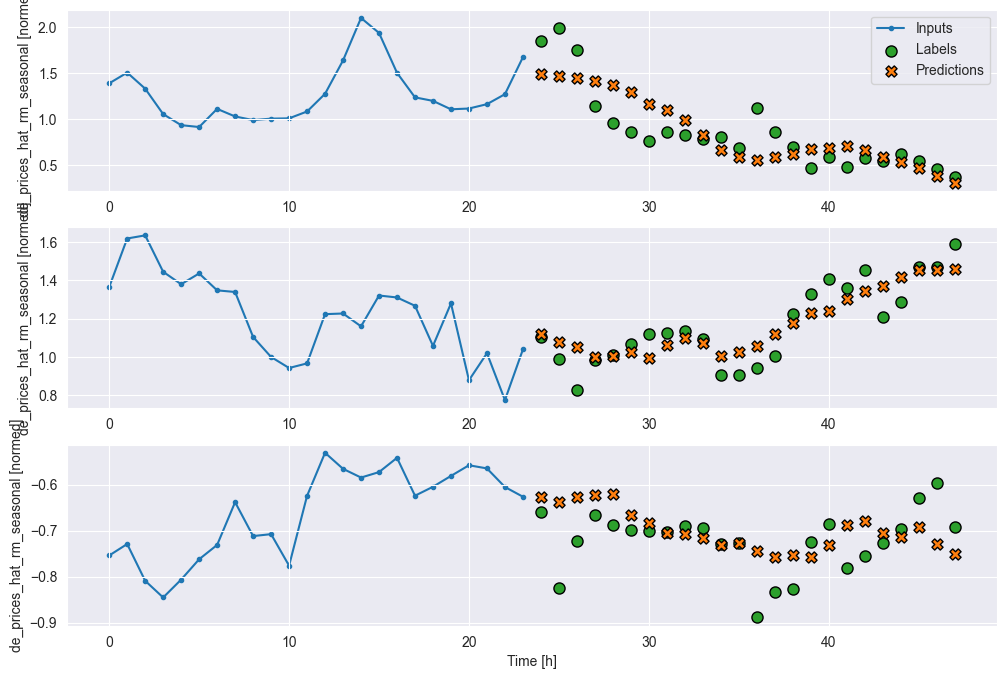

In [33]:
model = pipeline.best_model
window.plot(model)

In [35]:
with open("../data/processed/seasonal_components.pkl", "rb") as f:
    seasonal_components = pkl.load(f)

predictions = pipeline.predictions

In [15]:
seasonal_components["de_load_rm_seasonal"].seasonal

,seasonal_24,seasonal_168
timestamp,,
2022-12-31 23:00:00+00:00,-7141.697120,-3760.953897
2023-01-01 00:00:00+00:00,-9030.917392,-3249.732934
2023-01-01 01:00:00+00:00,-9651.483154,-3213.394004
2023-01-01 02:00:00+00:00,-9911.868482,-3663.666130
2023-01-01 03:00:00+00:00,-9577.611133,-4283.472236
...,...,...
2024-12-31 18:00:00+00:00,6617.831529,-1497.034700
2024-12-31 19:00:00+00:00,4019.237128,-1726.727115
2024-12-31 20:00:00+00:00,1526.140870,-1568.881314


In [23]:
window.val.unbatch()

<_UnbatchDataset element_spec=(TensorSpec(shape=(24, 22), dtype=tf.float32, name=None), TensorSpec(shape=(24, 1), dtype=tf.float32, name=None))>

In [36]:
# flatten predictions into 2d array such that each row is a 24 hour series of predictions for the 0 index column feature
predictions_2d = predictions[:, :, 0].reshape(-1, 24)

In [37]:
predictions_2d

array([[ 0.22514723,  0.11519236,  0.04747567, ...,  0.60109603,
         0.623336  ,  0.6588531 ],
       [-0.66320425, -0.6728244 , -0.66978824, ..., -0.02236681,
        -0.08348978, -0.13729946],
       [ 0.43797463,  0.39078915,  0.3632272 , ..., -0.09883056,
        -0.16982882, -0.2175259 ],
       ...,
       [ 0.8670661 ,  0.7407269 ,  0.6540406 , ...,  0.4849315 ,
         0.6452306 ,  0.7668673 ],
       [ 0.78400785,  0.76192   ,  0.74648017, ..., -0.19135433,
        -0.26999313, -0.33329546],
       [ 0.5756783 ,  0.5040375 ,  0.43413597, ..., -0.7282642 ,
        -0.81070894, -0.8564977 ]], dtype=float32)

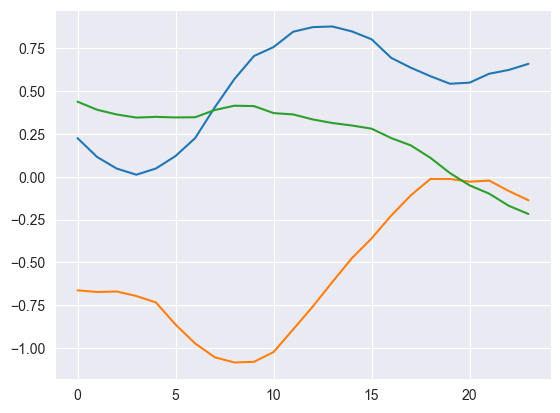

In [38]:
plt.plot(predictions_2d[0], label='Predictions')
plt.plot(predictions_2d[1], label='Predictions')
plt.plot(predictions_2d[2], label='Predictions')